而是将一季度的财务数据填充到trdmnt=5月，中报的数据（Accper=YYYY-6-31）的数据填充到8,9月，三季报数据填充11,12加次年1,2,3,4月
将4月的di.stk_mkt_valuationmetrics_monthly1的数据填充到5月（滞后一个月）

In [2]:
# 1. 确保已安装必要的库
# 如果尚未安装，请在 notebook 的一个单元格中运行以下命令
# !pip install polars sqlalchemy psycopg2-binary ipython connectorx

import polars as pl
import os
from IPython.display import display # 导入 display 函数

# 2. 设置数据库连接信息
# 建议使用环境变量来管理敏感信息，避免硬编码
# 您需要根据您的实际情况替换下面的'...'部分
db_user = 'panjinhe'
db_password = '20020112p'  # 替换为您的数据库密码
db_host = 'localhost'          # 或者您的数据库服务器IP地址
db_port = '5432'               # 默认的PostgreSQL端口
db_name = 'pbroe'       # 替换为您的数据库名称

# 构建数据库连接URI
db_uri = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"

# 3. 定义要执行的SQL查询
query = "SELECT * FROM pbroe.pbroech8;"

print("--- 步骤 1: 从数据库读取数据到 pbroech8_pl ---")

pbroech8_pl = None # 先将变量初始化为 None
try:
    # 4. 使用 polars.read_database_uri 读取数据
    pbroech8_pl = pl.read_database_uri(
        query=query,
        uri=db_uri
    )

    print("数据成功导入！")
    print(f"成功导入 {pbroech8_pl.shape[0]} 行, {pbroech8_pl.shape[1]} 列数据到变量 pbroech8_pl。")
    print("\n数据预览 (前5行):")
    display(pbroech8_pl.head())

    # --- 【【新增步骤】】: 将数据导出到文件 ---
    print("\n--- 步骤 2: 将导入的数据导出到 CSV 文件 ---")
    output_path = "E:/PBROE/ch8/pbroe8_data_from_db.csv"

    # 确保输出目录存在
    output_dir = os.path.dirname(output_path)
    os.makedirs(output_dir, exist_ok=True)

    # 写入 CSV 文件
    pbroech8_pl.write_csv(output_path)
    print(f"数据已成功导出到: {output_path}")


except Exception as e:
    print(f"数据处理失败，发生错误: {e}")
    pbroech8_pl = None # 确保在失败时变量为None



--- 步骤 1: 从数据库读取数据到 pbroech8_pl ---
数据成功导入！
成功导入 784086 行, 25 列数据到变量 pbroech8_pl。

数据预览 (前5行):


stkcd,trdmnt,accper,shortname,if_st,indcd1,indnme1,price,market_cap,total_shares,PB,PE2TTM,DividendYieldRatio,roe_ttm,roic,eps_ttm_core,eps_ttm_total,total_equity,ar,inventory,intangibles,onaps,arps,invps,iaps
str,str,date,str,i32,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""000001""","""1992-05""",1991-12-31,"""深发展A""",0,"""J66""","""货币金融服务""",45.2,6.0883e9,1.34696625e8,null,null,null,null,null,null,null,5.7796e8,0.0,0.0,0.0,4.290828,0.0,0.0,0.0
"""000001""","""1992-06""",1991-12-31,"""深发展A""",0,"""J66""","""货币金融服务""",42.0,5.6573e9,1.34696625e8,null,null,null,null,null,null,null,5.7796e8,0.0,0.0,0.0,4.290828,0.0,0.0,0.0
"""000001""","""1992-07""",1991-12-31,"""深发展A""",0,"""J66""","""货币金融服务""",45.6,6.1422e9,1.34696625e8,null,null,null,null,null,null,null,5.7796e8,0.0,0.0,0.0,4.290828,0.0,0.0,0.0
"""000001""","""1992-08""",1991-12-31,"""深发展A""",0,"""J66""","""货币金融服务""",41.25,5.5562e9,1.3470e8,null,null,null,null,null,null,null,5.7796e8,0.0,0.0,0.0,4.290828,0.0,0.0,0.0
"""000001""","""1992-09""",1991-12-31,"""深发展A""",0,"""J66""","""货币金融服务""",44.6,6.0075e9,1.3470e8,null,null,null,null,null,null,null,5.7796e8,0.0,0.0,0.0,4.290828,0.0,0.0,0.0



--- 步骤 2: 将导入的数据导出到 CSV 文件 ---
数据已成功导出到: E:/PBROE/ch8/pbroe8_data_from_db.csv


In [15]:
# 残差计算
import polars as pl
import numpy as np
import statsmodels.api as sm
import os
from IPython.display import display
import numba

# =================================================================== #
#                       【模块一: 价格模型与PBadj计算 (向量化优化版)】   #
# =================================================================== #

def calculate_pbadj_vectorized(df: pl.DataFrame) -> pl.DataFrame:
    """
    (核心流程函数 - 优化版) 在一个完全向量化的流程中，计算 b_adj_ps 和 PBadj。
    该版本避免了对每个分组应用Python函数，从而大幅提升性能。
    """
    print("\n--- 开始计算 [PBadj] 因子 (向量化版本) ---")

    # 1. 数据预处理
    y_col = 'price'
    x_cols = ['onaps', 'arps', 'invps', 'iaps', 'eps_ttm_core']
    all_vars = [y_col] + x_cols

    df_clean = df.drop_nulls(subset=all_vars)
    print(f"PBadj 模型: 数据预处理后剩余 {df_clean.height} 条记录。")

    # 2. 一次性计算所有回归所需的统计量 (均值、协方差矩阵的元素)
    group_cols = ['trdmnt', 'indcd1']

    # 构建协方差计算表达式
    cov_exprs = []
    for i in range(len(all_vars)):
        for j in range(i, len(all_vars)):
            var1_orig = all_vars[i]
            var2_orig = all_vars[j]
            # 【【【代码修改】】】: 保证协方差的别名始终按字母顺序，以避免 ColumnNotFoundError
            var1_sorted, var2_sorted = sorted([var1_orig, var2_orig])
            cov_exprs.append(pl.cov(var1_orig, var2_orig).alias(f'cov_{var1_sorted}_{var2_sorted}'))

    # 分组计算统计量
    stats_df = df_clean.group_by(group_cols).agg(
        [pl.mean(c).alias(f'mean_{c}') for c in all_vars] +
        cov_exprs +
        [pl.len().alias('n')]
    ).filter(pl.col('n') >= 10)
    print("回归所需统计量计算完成。")

    # 3. 在Polars表达式中直接求解5元线性回归的系数
    # 对于 Y = b0 + b1*X1 + b2*X2 + b3*X3 + b4*X4 + b5*X5
    # 系数可以通过求解正规方程 (X'X)b = X'Y 得到
    # 这里我们将直接使用协方差矩阵来求解，避免处理大量的和与平方和

    # 构造协方差矩阵 S_xx 和 协方差向量 S_xy
    # S_xx is a 5x5 matrix, S_xy is a 5x1 vector
    s_xx_exprs = []
    for x1 in x_cols:
        row = []
        for x2 in x_cols:
            # 保证列名顺序一致
            c1, c2 = sorted([x1, x2])
            row.append(pl.col(f'cov_{c1}_{c2}'))
        s_xx_exprs.append(pl.concat_list(row).alias(x1))

    s_xy_exprs = [pl.col(f'cov_{sorted([x, y_col])[0]}_{sorted([x, y_col])[1]}') for x in x_cols]

    # 将S_xx和S_xy打包成struct以便后续处理
    packed_stats = stats_df.with_columns(
        s_xx=pl.struct(s_xx_exprs),
        s_xy=pl.concat_list(s_xy_exprs)
    )

    # 4. 定义一个函数来为单行(分组)数据求解系数
    def solve_ols_for_row(row: dict) -> dict:
        """
        接收一个包含 s_xx (协方差矩阵) 和 s_xy (协方差向量) 的字典，
        返回一个包含回归系数的字典。
        """
        s_xx_dict = row['s_xx']
        s_xy_list = row['s_xy']

        # 从字典重构 numpy 矩阵
        s_xx_mat = np.array([s_xx_dict[k] for k in x_cols])
        s_xy_vec = np.array(s_xy_list)

        try:
            # 使用 np.linalg.solve 求解线性方程组 S_xx * b = S_xy
            betas = np.linalg.solve(s_xx_mat, s_xy_vec)
            # 【【【代码修改】】】: 返回一个字典，而不是元组
            return {f'field_{i}': val for i, val in enumerate(betas)}
        except np.linalg.LinAlgError:
            # 如果矩阵是奇异的 (不可逆)，则返回一个包含None的字典
            return {f'field_{i}': None for i in range(len(x_cols))}

    # 为 map_elements 定义返回类型，这对于性能和类型稳定性至关重要
    beta_fields = [pl.Field(f'field_{i}', pl.Float64) for i in range(len(x_cols))]
    return_dtype = pl.Struct(beta_fields)

    # 计算系数 b1, b2, ..., b5
    coeffs_df = packed_stats.select(
        group_cols +
        [
            pl.struct(['s_xx', 's_xy']).map_elements(
                solve_ols_for_row,
                return_dtype=return_dtype,
                strategy="thread_local"
            ).alias('betas')
        ]
    ).unnest('betas')

    # 重命名系数b1..b5
    beta_names = {f'field_{i}': f'beta_{x_cols[i]}' for i in range(len(x_cols))}
    coeffs_df = coeffs_df.rename(beta_names)

    # 计算截距 b0
    mean_terms = [pl.col(f'beta_{x}') * pl.col(f'mean_{x}') for x in x_cols]
    b0_expr = pl.col(f'mean_{y_col}') - pl.sum_horizontal(mean_terms)

    coeffs_df = coeffs_df.join(stats_df.select(group_cols + [f'mean_{c}' for c in all_vars]), on=group_cols)
    coeffs_df = coeffs_df.with_columns(b0=b0_expr)
    print("回归系数计算完成。")

    # 5. 将系数连接回原始数据并计算 PBadj
    df_with_coeffs = df_clean.join(coeffs_df.select(group_cols + ['b0'] + [f'beta_{x}' for x in x_cols]), on=group_cols, how='inner')

    df_with_pbadj = df_with_coeffs.with_columns(
        # 仅在 beta_onaps > 0 时进行计算
        b_adj_ps=pl.when(pl.col('beta_onaps') > 0).then(
            pl.col('onaps') +
            (pl.col('beta_arps') / pl.col('beta_onaps')) * pl.col('arps') +
            (pl.col('beta_invps') / pl.col('beta_onaps')) * pl.col('invps') +
            (pl.col('beta_iaps') / pl.col('beta_onaps')) * pl.col('iaps')
        ).otherwise(None)
    ).drop_nulls('b_adj_ps').with_columns(
        PBadj=pl.col('price') / pl.col('b_adj_ps')
    ).filter(
        pl.col('PBadj').is_finite() & (pl.col('PBadj') > 0)
    )
    print("PBadj 计算完成。")

    return df_with_pbadj.select(['stkcd', 'trdmnt', 'b_adj_ps', 'PBadj'])


# =================================================================== #
#                  【模块二: 通用向量化回归与残差计算】                 #
# =================================================================== #

def run_vectorized_regression(df: pl.DataFrame, y_col: str, x_cols: list, group_cols: list) -> pl.DataFrame:
    """
    (通用函数) 执行全向量化分组回归，并返回带有残差的DataFrame。
    """
    print(f"\n--- 开始向量化回归: {y_col} ~ {' + '.join(x_cols)} ---")

    # 1. 一次性计算所有回归所需的统计量
    agg_exprs = [pl.mean(y_col).alias(f'mean_{y_col}')]
    for x_col in x_cols:
        agg_exprs.append(pl.mean(x_col).alias(f'mean_{x_col}'))
        agg_exprs.append(pl.var(x_col).alias(f'var_{x_col}'))
        agg_exprs.append(pl.cov(x_col, y_col).alias(f'cov_{x_col}_{y_col}'))
        for x_col_other in x_cols:
            if x_col < x_col_other:
                 agg_exprs.append(pl.cov(x_col, x_col_other).alias(f'cov_{x_col}_{x_col_other}'))
    agg_exprs.append(pl.len().alias('n'))

    stats_df = df.group_by(group_cols).agg(agg_exprs).filter(pl.col('n') >= 15)

    # 2. 根据OLS公式计算回归系数 (以2个自变量为例)
    #    注意：此处的公式是为2个自变量硬编码的。若自变量数量变化，需调整。
    x1, x2 = x_cols[0], x_cols[1]

    # 【代码修正】: 确保协方差列名与生成时一致
    sorted_x = sorted([x1, x2])
    cov_x1_x2_col_name = f'cov_{sorted_x[0]}_{sorted_x[1]}'

    denominator = (pl.col(f'var_{x1}') * pl.col(f'var_{x2}')) - (pl.col(cov_x1_x2_col_name) ** 2)
    safe_denominator = pl.when(denominator.abs() < 1e-9).then(1e-9).otherwise(denominator)

    stats_df = stats_df.with_columns(
        b1=((pl.col(f'var_{x2}') * pl.col(f'cov_{x1}_{y_col}')) - (pl.col(cov_x1_x2_col_name) * pl.col(f'cov_{x2}_{y_col}'))) / safe_denominator,
        b2=((pl.col(f'var_{x1}') * pl.col(f'cov_{x2}_{y_col}')) - (pl.col(cov_x1_x2_col_name) * pl.col(f'cov_{x1}_{y_col}'))) / safe_denominator
    ).with_columns(
        b0=pl.col(f'mean_{y_col}') - (pl.col('b1') * pl.col(f'mean_{x1}')) - (pl.col('b2') * pl.col(f'mean_{x2}'))
    )

    # 3. 将系数连接回数据集
    df_regged = df.join(stats_df.select(group_cols + ['b0', 'b1', 'b2']), on=group_cols, how='inner')

    # 4. 计算预测值和残差
    df_regged = df_regged.with_columns(
        predicted_y = pl.col('b0') + (pl.col('b1') * pl.col(x1)) + (pl.col('b2') * pl.col(x2))
    ).with_columns(
        residual = pl.col(y_col) - pl.col('predicted_y')
    )

    print(f"向量化回归完成。")
    return df_regged


# =================================================================== #
#                       【模块三: 计算分位数】                          #
# =================================================================== #

@numba.jit(nopython=True)
def rolling_rank_get_last_quantile(arr: np.ndarray) -> float:
    """
    一个被 Numba JIT 编译的函数，用于高速计算滚动窗口中最后一个值的百分位排名。
    它接收一个NumPy数组，返回一个浮点数。
    """
    if len(arr) == 0:
        return np.nan

    # 获取窗口中的最后一个值
    last_val = arr[-1]

    # 计算排名（采用 'average' 方法的逻辑）
    less_count = 0
    equal_count = 0
    for x in arr:
        if x < last_val:
            less_count += 1
        elif x == last_val:
            equal_count += 1

    # rank = (小于last_val的数量) + (等于last_val的数量 + 1) / 2
    rank = less_count + (equal_count + 1) / 2.0

    # 返回百分位排名
    return rank / len(arr)

def rolling_rank_wrapper(s: pl.Series) -> float:
    """
    包装器函数，将Polars Series转换为Numpy数组以供Numba函数使用。
    """
    return rolling_rank_get_last_quantile(s.to_numpy())


# =================================================================== #
#                          【主执行流程】                             #
# =================================================================== #

def main(data_df: pl.DataFrame):
    """主执行函数"""
    # --- 步骤 1: 验证输入数据 ---
    if data_df is None:
        print("错误: 传入的数据 (data_df) 为空。程序终止。")
        return
    print("--- 步骤 1: 数据验证通过 ---")
    print(f"接收到 {data_df.height} 行数据进行处理。")


    # --- 步骤 2: 计算模型一 (传统PB-ROE模型) 的残差 ---
    df_cleaned_model1 = data_df.with_columns(
        (pl.col("DividendYieldRatio").fill_null(0) * pl.col("PE2TTM")).alias("d_payout_ratio"),
        pl.col("PB").log().alias("lnPB")
    ).with_columns(
        (pl.col("d_payout_ratio") * pl.col("roe_ttm")).alias("d_roe")
    ).filter(
        (pl.col("PB") > 0) & (pl.col("PE2TTM") > 0) &
        (pl.col("roe_ttm").is_not_null()) &
        (pl.col("roe_ttm").is_between(-0.1, 0.5)) &
        (pl.col("indnme1").is_not_null()) & (pl.col("if_st") == 0)
    )
    print(f"传统 PB-ROE 模型: 数据清洗后剩余 {df_cleaned_model1.height} 条记录。")

    model1_results = run_vectorized_regression(
        df=df_cleaned_model1,
        y_col='lnPB',
        x_cols=['roe_ttm', 'd_roe'],
        group_cols=['trdmnt', 'indnme1']
    )
    # 重命名残差列以区分
    model1_results = model1_results.rename({"residual": "residual_pb_roe"})


    # --- 步骤 3: 计算模型二 (PBadj) ---
    # 调用优化后的向量化函数
    pbadj_results = calculate_pbadj_vectorized(data_df)


    # --- 步骤 4: 计算模型三 (PBadj-ROE模型) 的标准化残差 ---
    # 1. 合并 PBadj 结果，并计算新模型的变量
    print("\n--- 开始计算 [residual_adj] 因子 (PBadj-ROE 模型) ---")
    df_for_model3 = data_df.join(pbadj_results, on=['stkcd', 'trdmnt'], how='inner')
    df_cleaned_model3 = df_for_model3.with_columns(
        pl.col('PBadj').log().alias('lnPBadj'),
        (pl.col('roe_ttm') - 0.03).alias('leverage_spread_roe') # 假设无风险利率为3%
    ).filter(
        pl.col('roe_ttm').is_not_null() & pl.col('leverage_spread_roe').is_not_null()
    )
    print(f"PBadj-ROE 模型: 数据清洗后剩余 {df_cleaned_model3.height} 条记录。")

    # 2. 运行回归
    model3_results = run_vectorized_regression(
        df=df_cleaned_model3,
        y_col='lnPBadj',
        x_cols=['roe_ttm', 'leverage_spread_roe'],
        group_cols=['trdmnt', 'indnme1']
    )

    # 3. 计算标准化残差 (residual_adj)
    model3_results = model3_results.with_columns(
        residual_adj=(
            (pl.col('residual') - pl.col('residual').mean().over(['trdmnt', 'indnme1'])) /
            pl.col('residual').std(ddof=0).over(['trdmnt', 'indnme1'])
        ).fill_nan(0.0)
    )
    print("residual_adj 计算完成。")


    # --- 步骤 5: 整合所有结果 ---
    print("\n--- 步骤 5: 整合所有模型结果 ---")
    # 选择各模型的核心结果列
    res1 = model1_results.select(['stkcd', 'trdmnt', 'residual_pb_roe'])
    res2 = pbadj_results.select(['stkcd', 'trdmnt', 'PBadj'])
    res3 = model3_results.select(['stkcd', 'trdmnt', 'residual_adj'])

    # 以原始数据为基础，左连接所有结果
    final_results = data_df.join(
        res1, on=['stkcd', 'trdmnt'], how='left'
    ).join(
        res2, on=['stkcd', 'trdmnt'], how='left'
    ).join(
        res3, on=['stkcd', 'trdmnt'], how='left'
    )

    # --- 步骤 6: 计算 residual_pb_roe 的滚动分位数 ---
    print("\n--- 步骤 6: 计算滚动分位数 ---")

    # 【【【代码修改】】】: 滚动窗口计算前必须先对数据排序
    # 确保每个分组 ('stkcd') 内的数据是按时间 ('trdmnt') 排列的
    final_results_sorted = final_results.sort("stkcd", "trdmnt")

    quantile_df = final_results_sorted.select(
        pl.col("stkcd"),
        pl.col("trdmnt"),
        pl.col("residual_pb_roe")
            .rolling_map(
                function=rolling_rank_wrapper,
                window_size=10,
                min_samples=10,
            )
            .over("stkcd")
            .alias("residual_quantile")
    )

    final_results = final_results.join(quantile_df, on=['stkcd', 'trdmnt'], how='left')
    print("滚动分位数计算完成。")

    # --- 步骤 7: 格式化并保存最终结果 ---
    print("\n--- 步骤 7: 格式化并保存最终结果 ---")
    # 保存前格式化 trdmnt 列
    final_results_formatted = final_results.with_columns(
        pl.col("trdmnt").dt.strftime("%Y-%m")
    )

    # 保存到文件
    output_path = "E:/PBROE/ch8/pbroe8.1_residuals_combined.csv"
    output_dir = os.path.dirname(output_path)
    os.makedirs(output_dir, exist_ok=True)

    final_results_formatted.write_csv(output_path)
    print(f"所有计算完成，最终结果已保存至: {output_path}")
    print(f"最终数据集包含 {final_results_formatted.height} 行。")

    # 预览最终结果
    print("\n预览最终结果（部分关键列）:")
    display(final_results_formatted.select([
        'stkcd', 'trdmnt', 'shortname', 'PB', 'PBadj', 'residual_pb_roe', 'residual_adj', 'residual_quantile'
    ]).tail())


if __name__ == "__main__":
    # =================================================================== #
    #                       【脚本执行入口】                                #
    # =================================================================== #

    # --- 1. 加载数据 ---
    print("--- 正在加载数据... ---")
    pbroech8_pl = None # 先初始化为 None
    try:
        # 使用 schema_overrides 替代已弃用的 dtypes
        pbroech8_pl = pl.read_csv(
            "E:/PBROE/ch8/pbroe8_data_from_db.csv",
            schema_overrides={"stkcd": pl.String}
        ).with_columns(
             pl.col('trdmnt').str.to_date('%Y-%m', strict=False) # 使用 strict=False 增加容错性
        )
        print(f"数据成功加载！共 {pbroech8_pl.height} 行, {pbroech8_pl.width} 列。")
    except Exception as e:
        print(f"数据加载失败: {e}")

    # --- 2. 调用主处理函数 ---
    # 只有在数据成功加载后才执行 main 函数
    if pbroech8_pl is not None:
        main(pbroech8_pl)


--- 正在加载数据... ---
数据成功加载！共 784086 行, 25 列。
--- 步骤 1: 数据验证通过 ---
接收到 784086 行数据进行处理。
传统 PB-ROE 模型: 数据清洗后剩余 581830 条记录。

--- 开始向量化回归: lnPB ~ roe_ttm + d_roe ---
向量化回归完成。

--- 开始计算 [PBadj] 因子 (向量化版本) ---
PBadj 模型: 数据预处理后剩余 692783 条记录。
回归所需统计量计算完成。
回归系数计算完成。
PBadj 计算完成。

--- 开始计算 [residual_adj] 因子 (PBadj-ROE 模型) ---
PBadj-ROE 模型: 数据清洗后剩余 549925 条记录。

--- 开始向量化回归: lnPBadj ~ roe_ttm + leverage_spread_roe ---
向量化回归完成。
residual_adj 计算完成。

--- 步骤 5: 整合所有模型结果 ---

--- 步骤 6: 计算滚动分位数 ---
滚动分位数计算完成。

--- 步骤 7: 格式化并保存最终结果 ---
所有计算完成，最终结果已保存至: E:/PBROE/ch8/pbroe8.1_residuals_combined.csv
最终数据集包含 784086 行。

预览最终结果（部分关键列）:


stkcd,trdmnt,shortname,PB,PBadj,residual_pb_roe,residual_adj,residual_quantile
str,str,str,f64,f64,f64,f64,f64
"""689009""","""2025-02""","""九号公司""",0.657539,5.978944,-1.99455,0.976814,0.4
"""689009""","""2025-03""","""九号公司""",0.750158,7.413134,-1.844271,1.302237,0.6
"""689009""","""2025-04""","""九号公司""",0.669154,7.135306,-1.79086,1.24226,0.7
"""689009""","""2025-05""","""九号公司""",0.699759,7.142528,-2.031774,1.162087,0.4
"""689009""","""2025-06""","""九号公司""",0.632463,6.554622,-2.260574,0.924577,0.1


In [16]:
#  模型: lnPB ~ roic + (roe - roic) + d*roic + d*(roe-roic)           #
#  在第8章模型基础上，将ROE分解为ROIC和杠杆利差(ROE-ROIC)           #
# =================================================================== #

import polars as pl
import numpy as np
from pathlib import Path
from IPython.display import display

def run_vectorized_regression_n_vars(
    df: pl.DataFrame,
    y_col: str,
    x_cols: list[str],
    group_cols: list[str]
) -> pl.DataFrame:
    """
    (通用函数) 对任意数量的自变量执行全向量化分组回归。
    返回带有回归系数、预测值和残差的DataFrame。
    """
    print(f"\n--- 开始通用向量化回归: {y_col} ~ {' + '.join(x_cols)} ---")

    all_vars = [y_col] + x_cols

    # 1. 一次性计算所有回归所需的统计量 (均值、协方差)
    cov_exprs = []
    for i in range(len(all_vars)):
        for j in range(i, len(all_vars)):
            var1_orig, var2_orig = all_vars[i], all_vars[j]
            var1_sorted, var2_sorted = sorted([var1_orig, var2_orig])
            cov_exprs.append(pl.cov(var1_orig, var2_orig).alias(f'cov_{var1_sorted}_{var2_sorted}'))

    stats_df = df.group_by(group_cols).agg(
        [pl.mean(c).alias(f'mean_{c}') for c in all_vars] +
        cov_exprs +
        [pl.len().alias('n')]
    ).filter(pl.col('n') >= 20) # 要求至少20个样本
    print("回归所需统计量计算完成。")

    # 2. 将统计量打包，准备用于求解线性方程组
    s_xx_exprs = [
        pl.concat_list([
            pl.col(f'cov_{sorted([x1, x2])[0]}_{sorted([x1, x2])[1]}') for x2 in x_cols
        ]).alias(x1) for x1 in x_cols
    ]
    s_xy_exprs = [pl.col(f'cov_{sorted([x, y_col])[0]}_{sorted([x, y_col])[1]}') for x in x_cols]

    packed_stats = stats_df.with_columns(
        s_xx=pl.struct(s_xx_exprs),
        s_xy=pl.concat_list(s_xy_exprs)
    )

    # 3. 定义一个函数，为每个分组 (row) 解算回归系数
    def solve_ols_for_row(row: dict) -> dict:
        s_xx_mat = np.array([row['s_xx'][k] for k in x_cols])
        s_xy_vec = np.array(row['s_xy'])
        try:
            betas = np.linalg.solve(s_xx_mat, s_xy_vec)
            return {f'beta_{i+1}': val for i, val in enumerate(betas)}
        except np.linalg.LinAlgError:
            return {f'beta_{i+1}': None for i in range(len(x_cols))}

    # 定义返回类型以提高性能
    beta_fields = [pl.Field(f'beta_{i+1}', pl.Float64) for i in range(len(x_cols))]
    return_dtype = pl.Struct(beta_fields)

    # 4. 计算斜率系数 (b1, b2, ...)
    coeffs_df = packed_stats.select(
        group_cols +
        [
            pl.struct(['s_xx', 's_xy']).map_elements(
                solve_ols_for_row,
                return_dtype=return_dtype,
                strategy="thread_local"
            ).alias('betas')
        ]
    ).unnest('betas')

    # 5. 计算截距 (b0)
    mean_terms = [pl.col(f'beta_{i+1}') * pl.col(f'mean_{x_cols[i]}') for i in range(len(x_cols))]
    b0_expr = pl.col(f'mean_{y_col}') - pl.sum_horizontal(mean_terms)

    coeffs_df = coeffs_df.join(stats_df.select(group_cols + [f'mean_{c}' for c in all_vars]), on=group_cols)
    coeffs_df = coeffs_df.with_columns(b0=b0_expr)
    print("回归系数计算完成。")

    # 6. 将系数连接回数据集，并计算预测值和残差
    df_regged = df.join(coeffs_df, on=group_cols, how='inner')

    prediction_expr = pl.col('b0') + pl.sum_horizontal(
        [pl.col(f'beta_{i+1}') * pl.col(x_cols[i]) for i in range(len(x_cols))]
    )

    df_regged = df_regged.with_columns(
        predicted_y=prediction_expr
    ).with_columns(
        residual=(pl.col(y_col) - pl.col('predicted_y'))
    )
    print(f"向量化回归完成。")
    return df_regged

def main_new_regression():
    """主执行函数：运行新回归并更新文件"""

    file_path = Path("E:/PBROE/ch8/pbroe8.1_residuals_combined.csv")
    print(f"--- 步骤 1: 正在处理文件: {file_path} ---")

    # 1. 【【【代码修改】】】: 使用 schema_overrides 强制指定数据类型，避免类型推断错误
    schema_overrides = {
        "PB": pl.Float64,
        "PE2TTM": pl.Float64,
        "DividendYieldRatio": pl.Float64,
        "roe_ttm": pl.Float64,
        "roic": pl.Float64,
        "stkcd": pl.Utf8
    }

    # 使用惰性计算来准备数据
    lazy_df = pl.scan_csv(file_path, schema_overrides=schema_overrides).with_columns(
        pl.col('trdmnt').str.to_date(format='%Y-%m', strict=False)
    )

    # 2. 创建回归所需的变量
    df_cleaned = lazy_df.with_columns(
        (pl.col("DividendYieldRatio").fill_null(0) * pl.col("PE2TTM")).alias("d_payout_ratio"),
        pl.col("PB").log().alias("lnPB"),
        (pl.col("roe_ttm") - pl.col("roic")).alias("roe_spread") # 杠杆利差
    ).with_columns(
        (pl.col("d_payout_ratio") * pl.col("roic")).alias("d_roic"), # 派息与ROIC的交互
        (pl.col("d_payout_ratio") * pl.col("roe_spread")).alias("d_roe_spread") # 派息与杠杆利差的交互
    ).filter(
        (pl.col("PB") > 0) & (pl.col("PE2TTM") > 0) &
        (pl.col("roe_ttm").is_not_null()) &
        (pl.col("roic").is_not_null()) &
        (pl.col("indnme1").is_not_null()) & (pl.col("if_st") == 0)
    ).collect() # 触发计算，为回归准备好数据

    print(f"新回归模型: 数据清洗后剩余 {df_cleaned.height} 条记录。")

    # 3. 执行新模型的回归
    model_results = run_vectorized_regression_n_vars(
        df=df_cleaned,
        y_col='lnPB',
        x_cols=['roic', 'roe_spread', 'd_roic', 'd_roe_spread'],
        group_cols=['trdmnt', 'indnme1']
    )

    # 4. 选择需要合并的结果
    new_residuals = model_results.select(
        "stkcd", "trdmnt",
        pl.col("residual").alias("residual_pb_roic_full")
    )

    # 5. 加载原始数据，合并新残差并覆盖保存
    print(f"\n--- 步骤 2: 正在合并新残差并更新文件... ---")
    original_df = pl.read_csv(
        file_path,
        schema_overrides={"stkcd": pl.String}
    ).with_columns(
        pl.col('trdmnt').str.to_date(format='%Y-%m', strict=False)
    )

    # 左连接合并新列
    updated_df = original_df.join(new_residuals, on=['stkcd', 'trdmnt'], how='left')

    # 格式化日期列为 "YYYY-MM" 字符串以便保存
    updated_df_formatted = updated_df.with_columns(
        pl.col("trdmnt").dt.strftime("%Y-%m")
    )

    # 覆盖保存原文件
    updated_df_formatted.write_csv(file_path)

    print(f"文件已成功更新: {file_path}")
    print("预览新增的残差列:")
    display(updated_df.select(['stkcd', 'trdmnt', 'residual_pb_roe', 'residual_adj', 'residual_pb_roic_full']).tail())


# --- 执行新回归流程 ---
main_new_regression()


--- 步骤 1: 正在处理文件: E:\PBROE\ch8\pbroe8.1_residuals_combined.csv ---
新回归模型: 数据清洗后剩余 577031 条记录。

--- 开始通用向量化回归: lnPB ~ roic + roe_spread + d_roic + d_roe_spread ---
回归所需统计量计算完成。
回归系数计算完成。
向量化回归完成。

--- 步骤 2: 正在合并新残差并更新文件... ---
文件已成功更新: E:\PBROE\ch8\pbroe8.1_residuals_combined.csv
预览新增的残差列:


stkcd,trdmnt,residual_pb_roe,residual_adj,residual_pb_roic_full
str,date,str,str,f64
"""689009""",2025-02-01,"""-1.9945501253144986""","""0.976813886518467""",-1.811816
"""689009""",2025-03-01,"""-1.8442711601550403""","""1.3022370154409975""",-1.663265
"""689009""",2025-04-01,"""-1.7908599356309205""","""1.2422597030542835""",-1.638991
"""689009""",2025-05-01,"""-2.0317741959686164""","""1.162087306052219""",-2.006615
"""689009""",2025-06-01,"""-2.2605744309685067""","""0.9245767851898273""",-2.224781


In [16]:
import polars as pl
from IPython.display import display
from scipy.stats import t, f # 导入scipy用于计算p-value和F分布

# 假设 pbroech8_pl 已经存在于环境中
if 'pbroech8_pl' in locals() and pbroech8_pl is not None:
    print("\n--- 步骤 1: 准备年度回归数据 (仅5月份, 2010-2024年) ---")

    # 1. 特征工程与数据清洗
    annual_pl = (
        pbroech8_pl
        .with_columns(
            pl.col("trdmnt").str.slice(0, 4).cast(pl.Int32).alias("year"),
            pl.col("DividendYieldRatio").fill_null(0).alias("DividendYieldRatio_filled")
        )
        .filter(pl.col("trdmnt").str.slice(5, 2) == '05')
        .filter((pl.col("year") >= 2010) & (pl.col("year") <= 2024))
        .with_columns(
            (pl.col("DividendYieldRatio_filled") * pl.col("PE2TTM")).alias("d_payout_ratio"),
            pl.col("PB").log().alias("lnPB")
        )
        .with_columns(
            (pl.col("d_payout_ratio") * pl.col("roe_ttm")).alias("d_roe")
        )
        .filter(
            (pl.col("PB") > 0) &
            (pl.col("PE2TTM") > 0) &
            (pl.col("roe_ttm").is_not_null()) &
            (pl.col("roe_ttm") > -0.1) & (pl.col("roe_ttm") < 0.5) &
            (pl.col("if_st") == 0)
        )
    )
    print("年度数据准备完成。")

    print("\n--- 步骤 2: 执行年度全市场回归，并计算完整诊断统计量 ---")
    y_col, x1_col, x2_col = 'lnPB', 'roe_ttm', 'd_roe'
    group_cols = ['year']
    k = 2 # 自变量个数

    stats_pl = annual_pl.group_by(group_cols).agg(
        pl.mean(y_col).alias(f'mean_{y_col}'),
        pl.mean(x1_col).alias(f'mean_{x1_col}'),
        pl.mean(x2_col).alias(f'mean_{x2_col}'),
        pl.var(y_col).alias(f'var_{y_col}'),
        pl.var(x1_col).alias(f'var_{x1_col}'),
        pl.var(x2_col).alias(f'var_{x2_col}'),
        pl.cov(x1_col, y_col).alias(f'cov_{x1_col}_{y_col}'),
        pl.cov(x2_col, y_col).alias(f'cov_{x2_col}_{y_col}'),
        pl.cov(x1_col, x2_col).alias(f'cov_{x1_col}_{x2_col}'),
        pl.len().alias('n')
    ).filter(pl.col('n') >= 30)

    denominator = (pl.col(f'var_{x1_col}') * pl.col(f'var_{x2_col}')) - (pl.col(f'cov_{x1_col}_{x2_col}') ** 2)
    safe_denominator = pl.when(denominator.abs() < 1e-9).then(1e-9).otherwise(denominator)

    coeffs_pl = stats_pl.with_columns(
        b1=((pl.col(f'var_{x2_col}') * pl.col(f'cov_{x1_col}_{y_col}')) - (pl.col(f'cov_{x1_col}_{x2_col}') * pl.col(f'cov_{x2_col}_{y_col}'))) / safe_denominator,
        b2=((pl.col(f'var_{x1_col}') * pl.col(f'cov_{x2_col}_{y_col}')) - (pl.col(f'cov_{x1_col}_{x2_col}') * pl.col(f'cov_{x1_col}_{y_col}'))) / safe_denominator
    ).with_columns(
        b0=pl.col(f'mean_{y_col}') - (pl.col('b1') * pl.col(f'mean_{x1_col}')) - (pl.col('b2') * pl.col(f'mean_{x2_col}'))
    )

    # --- 【已修正】计算所有系数的标准误、t统计量、p值，以及模型的R²和F-statistic ---
    diagnostics_pl = coeffs_pl.with_columns(
        # 1. 计算R-squared和整体模型统计量
        SST = (pl.col('n') - 1) * pl.col(f'var_{y_col}'),
        SSR = (pl.col('b1') * (pl.col('n') - 1) * pl.col(f'cov_{x1_col}_{y_col}')) + \
              (pl.col('b2') * (pl.col('n') - 1) * pl.col(f'cov_{x2_col}_{y_col}'))
    ).with_columns(
        SSE = pl.col('SST') - pl.col('SSR'),
        R_squared = pl.col('SSR') / pl.col('SST')
    ).with_columns(
        adj_R_squared = 1 - ((1 - pl.col('R_squared')) * (pl.col('n') - 1) / (pl.col('n') - k - 1)),
        residual_variance = pl.col('SSE') / (pl.col('n') - k - 1),
        F_statistic = (pl.col('SSR') / k) / (pl.col('SSE') / (pl.col('n') - k - 1))
    ).with_columns(
        # 【已修正】步骤2.1: 创建计算方差所需的中间变量
        var_denominator = (pl.col('n') - 1) * safe_denominator,
        var_b0_term = (pl.col(f'mean_{x1_col}')**2 * pl.col(f'var_{x2_col}')) - \
                    (2 * pl.col(f'mean_{x1_col}') * pl.col(f'mean_{x2_col}') * pl.col(f'cov_{x1_col}_{x2_col}')) + \
                    (pl.col(f'mean_{x2_col}')**2 * pl.col(f'var_{x1_col}'))
    ).with_columns(
        # 【已修正】步骤2.2: 使用上一步的中间变量计算方差
        var_b1 = (pl.col('residual_variance') * pl.col(f'var_{x2_col}')) / pl.col('var_denominator'),
        var_b2 = (pl.col('residual_variance') * pl.col(f'var_{x1_col}')) / pl.col('var_denominator'),
        var_b0 = pl.col('residual_variance') * (1/pl.col('n') + pl.col('var_b0_term') / pl.col('var_denominator'))
    ).with_columns(
        # 3. 计算标准误 (Standard Error) 和 t-statistic
        se_b0 = pl.col('var_b0').sqrt(),
        se_b1 = pl.col('var_b1').sqrt(),
        se_b2 = pl.col('var_b2').sqrt()
    ).with_columns(
        t_stat_b0 = pl.col('b0') / pl.col('se_b0'),
        t_stat_b1 = pl.col('b1') / pl.col('se_b1'),
        t_stat_b2 = pl.col('b2') / pl.col('se_b2')
    ).with_columns(
        # 4. 计算 p-values
        p_value_b0 = pl.struct(['t_stat_b0', 'n']).map_elements(lambda x: 2 * (1 - t.cdf(abs(x['t_stat_b0']), df=x['n'] - k - 1)), return_dtype=pl.Float64),
        p_value_b1 = pl.struct(['t_stat_b1', 'n']).map_elements(lambda x: 2 * (1 - t.cdf(abs(x['t_stat_b1']), df=x['n'] - k - 1)), return_dtype=pl.Float64),
        p_value_b2 = pl.struct(['t_stat_b2', 'n']).map_elements(lambda x: 2 * (1 - t.cdf(abs(x['t_stat_b2']), df=x['n'] - k - 1)), return_dtype=pl.Float64),
        F_p_value = pl.struct(['F_statistic', 'n']).map_elements(lambda x: f.sf(x['F_statistic'], k, x['n'] - k - 1), return_dtype=pl.Float64)
    )

    print("\n--- 步骤 3: 显示各年度全市场回归的完整诊断结果 ---")

    pl.Config.set_tbl_rows(20)

    # 5. 显示模型整体诊断结果
    print("\n模型整体拟合优度与显著性:")
    display(
        diagnostics_pl.select([
            'year', 'n',
            pl.col('R_squared').round(4),
            pl.col('adj_R_squared').round(4),
            pl.col('F_statistic').round(2),
            pl.col('F_p_value').round(4).alias('p_value(F)')
        ]).sort('year')
    )

    # 6. 显示各系数的详细诊断结果
    print("\n各回归系数的详细诊断:")
    display(
        diagnostics_pl.select([
            'year',
            pl.col('b0').round(4).alias('b0 (Intercept)'),
            pl.col('t_stat_b0').round(2).alias('t-stat(b0)'),
            pl.col('p_value_b0').round(4).alias('p-value(b0)'),
            pl.col('b1').round(4).alias('b1 (roe_ttm)'),
            pl.col('t_stat_b1').round(2).alias('t-stat(b1)'),
            pl.col('p_value_b1').round(4).alias('p-value(b1)'),
            pl.col('b2').round(4).alias('b2 (d_roe)'),
            pl.col('t_stat_b2').round(2).alias('t-stat(b2)'),
            pl.col('p_value_b2').round(4).alias('p-value(b2)'),
        ]).sort('year')
    )
else:
    print("错误: 'pbroech8_pl' DataFrame 不存在。请先运行前面的数据导入代码块。")




--- 步骤 1: 准备年度回归数据 (仅5月份, 2010-2024年) ---
年度数据准备完成。

--- 步骤 2: 执行年度全市场回归，并计算完整诊断统计量 ---

--- 步骤 3: 显示各年度全市场回归的完整诊断结果 ---

模型整体拟合优度与显著性:


year,n,R_squared,adj_R_squared,F_statistic,p_value(F)
i32,u32,f64,f64,f64,f64
2010,1280,0.0101,0.0086,6.54,0.0015
2011,1602,0.0194,0.0182,15.85,0.0
2012,1861,0.0347,0.0336,33.35,0.0
2013,2041,0.0364,0.0355,38.49,0.0
2014,2121,0.0235,0.0225,25.45,0.0
2015,2138,0.0178,0.0169,19.34,0.0
2016,2277,0.0342,0.0333,40.22,0.0
2017,2550,0.0678,0.067,92.59,0.0
2018,2933,0.1098,0.1092,180.71,0.0



各回归系数的详细诊断:


year,b0 (Intercept),t-stat(b0),p-value(b0),b1 (roe_ttm),t-stat(b1),p-value(b1),b2 (d_roe),t-stat(b2),p-value(b2)
i32,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010,0.8142,20.73,0.0,0.7686,2.73,0.0065,-0.0098,-2.99,0.0029
2011,0.6732,18.08,0.0,1.5783,5.47,0.0,-0.0248,-3.65,0.0003
2012,0.2893,8.65,0.0,2.3967,8.08,0.0,-0.0194,-2.88,0.004
2013,0.3057,9.39,0.0,2.8149,8.77,0.0,-0.0316,-4.18,0.0
2014,0.3818,11.99,0.0,2.2442,6.98,0.0,-0.0346,-4.79,0.0
2015,1.6714,60.82,0.0,1.762,6.21,0.0,-0.0159,-2.85,0.0045
2016,1.1348,46.21,0.0,2.1282,8.67,0.0,-0.01,-2.15,0.0317
2017,0.899,43.82,0.0,2.5529,13.46,0.0,-0.0031,-1.72,0.0857
2018,0.6658,34.4,0.0,2.7915,15.39,0.0,0.0097,3.34,0.0008



--- 步骤 1: 准备月度回归数据 (2010-05 to 2025-04) ---
月度数据准备完成。

--- 步骤 2: 执行月度全市场回归 ---
回归系数计算完成。

--- 步骤 3: 绘制b2系数的时间序列图 ---
成功找到并设置中文字体: SimHei


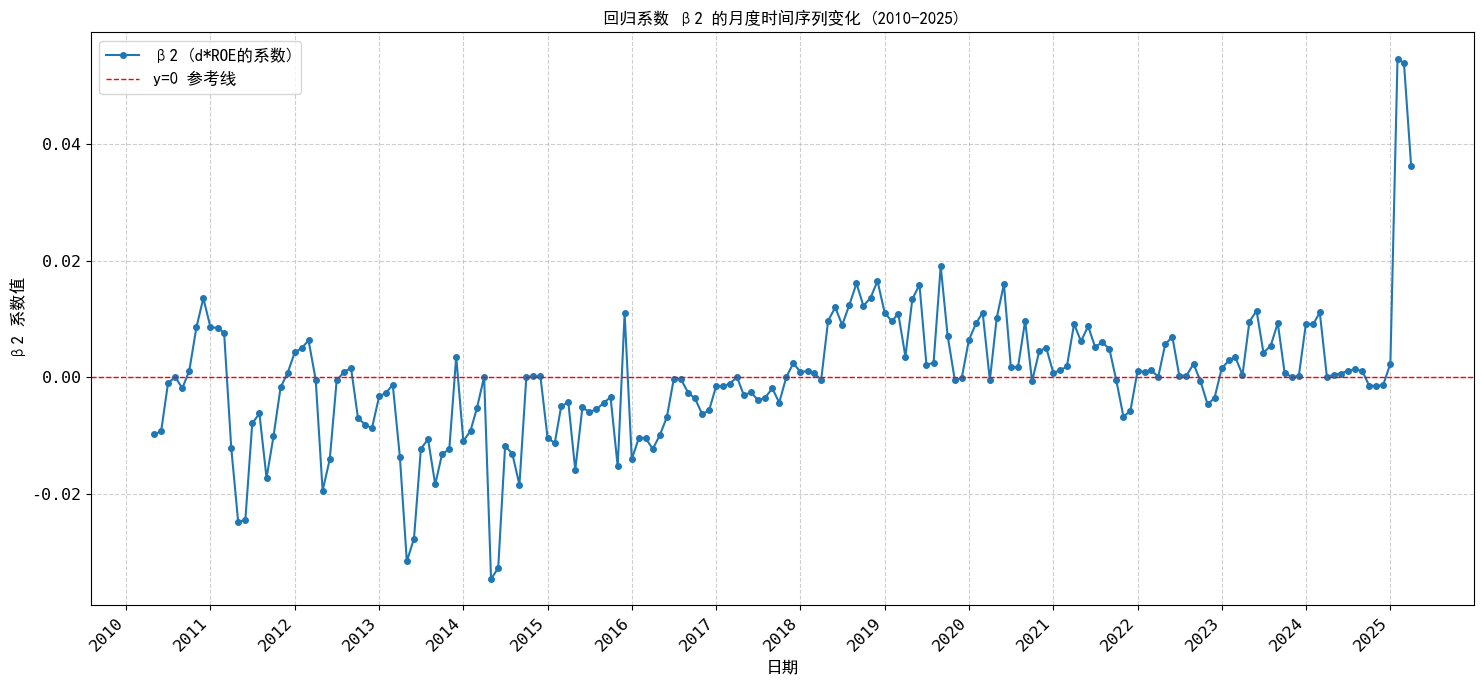

In [17]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import font_manager

def find_and_set_chinese_font():
    """
    动态查找系统中可用的中文字体并进行设置。
    返回一个可以强制应用到图表元素的 FontProperties 对象。
    """
    # 常见中文字体列表
    font_names = ['SimHei', 'Microsoft YaHei', 'DengXian', 'FangSong', 'KaiTi']

    for font_name in font_names:
        try:
            # font_manager.findfont 会在系统中查找字体文件
            prop = font_manager.FontProperties(fname=font_manager.findfont(font_manager.FontProperties(family=font_name)))
            print(f"成功找到并设置中文字体: {font_name}")
            # 仍然设置全局变量作为后备
            plt.rcParams['font.sans-serif'] = [font_name]
            plt.rcParams['axes.unicode_minus'] = False
            return prop
        except:
            continue

    print("警告: 在系统中未找到任何可用的中文字体 (如黑体, 微软雅黑等)。")
    print("请先在您的操作系统中安装至少一种中文字体，然后重启Jupyter内核再试。")
    return None

# 假设 pbroech8_pl 已经存在于环境中
if 'pbroech8_pl' in locals() and pbroech8_pl is not None:
    print("\n--- 步骤 1: 准备月度回归数据 (2010-05 to 2025-04) ---")

    # 1. 特征工程与数据清洗
    monthly_pl = (
        pbroech8_pl
        .filter((pl.col("trdmnt") >= "2010-05") & (pl.col("trdmnt") <= "2025-04"))
        .with_columns(
            pl.col("DividendYieldRatio").fill_null(0).alias("DividendYieldRatio_filled")
        )
        .with_columns(
            (pl.col("DividendYieldRatio_filled") * pl.col("PE2TTM")).alias("d_payout_ratio"),
            pl.col("PB").log().alias("lnPB")
        )
        .with_columns(
            (pl.col("d_payout_ratio") * pl.col("roe_ttm")).alias("d_roe")
        )
        .filter(
            (pl.col("PB") > 0) &
            (pl.col("PE2TTM") > 0) &
            (pl.col("roe_ttm").is_not_null()) &
            (pl.col("roe_ttm") > -0.1) & (pl.col("roe_ttm") < 0.5) &
            (pl.col("if_st") == 0)
        )
    )
    print("月度数据准备完成。")

    print("\n--- 步骤 2: 执行月度全市场回归 ---")
    y_col, x1_col, x2_col = 'lnPB', 'roe_ttm', 'd_roe'
    group_cols = ['trdmnt']

    stats_pl = monthly_pl.group_by(group_cols).agg(
        pl.var(x1_col).alias(f'var_{x1_col}'),
        pl.var(x2_col).alias(f'var_{x2_col}'),
        pl.cov(x1_col, y_col).alias(f'cov_{x1_col}_{y_col}'),
        pl.cov(x2_col, y_col).alias(f'cov_{x2_col}_{y_col}'),
        pl.cov(x1_col, x2_col).alias(f'cov_{x1_col}_{x2_col}'),
        pl.len().alias('n')
    ).filter(pl.col('n') >= 30)

    denominator = (pl.col(f'var_{x1_col}') * pl.col(f'var_{x2_col}')) - (pl.col(f'cov_{x1_col}_{x2_col}') ** 2)
    safe_denominator = pl.when(denominator.abs() < 1e-9).then(1e-9).otherwise(denominator)

    b2_series_pl = stats_pl.with_columns(
        b2=((pl.col(f'var_{x1_col}') * pl.col(f'cov_{x2_col}_{y_col}')) - (pl.col(f'cov_{x1_col}_{x2_col}') * pl.col(f'cov_{x1_col}_{y_col}'))) / safe_denominator
    ).select(['trdmnt', 'b2']).sort('trdmnt')

    b2_series_pl = b2_series_pl.with_columns(
        pl.col('trdmnt').str.to_date(format='%Y-%m').alias('date')
    )
    print("回归系数计算完成。")

    print("\n--- 步骤 3: 绘制b2系数的时间序列图 ---")

    # 【已修正】调用函数来动态查找并获取中文字体属性
    chinese_font_prop = find_and_set_chinese_font()

    # 只有在成功设置字体后才绘图
    if chinese_font_prop:
        fig, ax = plt.subplots(figsize=(15, 7))
        ax.plot(b2_series_pl['date'], b2_series_pl['b2'], marker='o', linestyle='-', markersize=4, label='β2 (d*ROE的系数)')
        ax.axhline(0, color='red', linestyle='--', linewidth=1, label='y=0 参考线')

        # 【已修正】强制为每个文本元素指定中文字体
        ax.set_title('回归系数 β2 的月度时间序列变化 (2010-2025)', fontsize=16, fontproperties=chinese_font_prop)
        ax.set_xlabel('日期', fontsize=12, fontproperties=chinese_font_prop)
        ax.set_ylabel('β2 系数值', fontsize=12, fontproperties=chinese_font_prop)
        ax.legend(prop=chinese_font_prop)

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

else:
    print("错误: 'pbroech8_pl' DataFrame 不存在。请先运行前面的数据导入代码块。")


In [18]:
# pbroe8.1_backtest_engine_polars.py
# 模仿 pbroe7_backtest_engine_polars.py, 针对 pbroe8.1 的残差数据进行回测
# 版本：Polars全向量化版 (高性能、高稳定性)
# 【修正版】: 修复了未来函数 (Lookahead Bias) 的问题

import polars as pl
import numpy as np
from pathlib import Path
import time

# =================================================================== #
#                       【1. 核心回测模块 (Polars)】                    #
# =================================================================== #

def run_grouped_backtest_polars(config):
    """
    (核心函数) 使用 Polars 全向量化方法，对所有分组一次性完成回测。
    """
    print("--- 步骤 1: 加载数据 (Polars) ---")
    try:
        # 加载策略分组数据
        strategy_df = pl.read_csv(config['RESIDUAL_FILE']).with_columns(
            pl.col('trdmnt').str.to_date(format='%Y-%m'),
            pl.col('stkcd').cast(pl.Utf8).str.zfill(6)
        )

        # 加载收益率数据
        returns_df = pl.read_csv(config['RETURNS_FILE']).select(
            pl.col('Stkcd').cast(pl.Utf8).str.zfill(6).alias('stkcd'),
            pl.col('Trdmnt').str.to_date(format='%Y-%m').alias('date'),
            pl.col('Mretwd').cast(pl.Float64, strict=False).alias('stock_return')
        )

        # 加载基准数据
        all_benchmarks_df = pl.read_csv(config['BENCHMARK_FILE'])
        benchmark_df = all_benchmarks_df.filter(
            pl.col('Indexcd').cast(pl.Utf8).str.zfill(6) == config['BENCHMARK_CODE']
        ).select(
            pl.col('Month').str.to_date(format='%Y-%m').alias('date'),
            pl.col('Idxrtn').alias('benchmark_return')
        )
        print("所有数据加载成功。")

    except Exception as e:
        print(f"错误: 加载数据时出错: {e}。程序终止。")
        return None, None

    print("\n--- 步骤 2: 构建投资组合并执行回测 (Polars) ---")

    # 1. 创建分组
    num_groups = config['NUM_GROUPS']
    strategy_df = strategy_df.with_columns(
        pl.col('residual_pb_roic_full').qcut(num_groups, labels=[f"G{i}" for i in range(1, num_groups + 1)])
          .alias('residual_group') #residual_adj,residual_quantile,residual_pb_roic_full
    ).drop_nulls('residual_group').rename({'trdmnt': 'date'})

    # 2. 【【【【【核心修正】】】】】修复未来函数 (Lookahead Bias)
    # 将策略日期向后推移一个月，以确保使用 T 月的信号匹配 T+1 月的收益
    print("正在修正未来函数：将策略日期向后推移一个月...")
    strategy_df = strategy_df.with_columns(
        pl.col("date").dt.offset_by("1mo")
    )

    # 3. 筛选回测周期
    start_date = pl.lit(config['BACKTEST_START_DATE']).str.to_date()
    end_date = pl.lit(config['BACKTEST_END_DATE']).str.to_date()
    strategy_df = strategy_df.filter(pl.col('date').is_between(start_date, end_date))

    # 4. 【核心向量化步骤】将策略数据与收益数据合并
    merged_df = strategy_df.join(returns_df, on=['date', 'stkcd'], how='inner')

    # 5. 【核心向量化步骤】一次性计算所有组在所有月份的平均收益
    monthly_returns = merged_df.group_by(['date', 'residual_group']).agg(
        pl.col('stock_return').mean()
    )

    # 6. 【核心向量化步骤】将结果从长格式转换为宽格式 (pivot)
    portfolio_returns_df = monthly_returns.pivot(
        index='date',
        on='residual_group',
        values='stock_return'
    ).sort('date')

    # 重命名列以匹配后续格式
    new_cols = {'date': 'date'}
    for i in range(1, num_groups + 1):
        if f'G{i}' in portfolio_returns_df.columns:
            new_cols[f'G{i}'] = f'portfolio_return_g{i}'
    portfolio_returns_df = portfolio_returns_df.rename(new_cols)

    # 填充缺失月份，确保时间序列连续
    full_date_range = pl.date_range(
        portfolio_returns_df.get_column('date').min(),
        portfolio_returns_df.get_column('date').max(),
        interval="1mo",
        eager=True
    ).alias("date")

    portfolio_returns_df = pl.DataFrame(full_date_range).join(
        portfolio_returns_df, on='date', how='left'
    ).fill_null(0.0)

    print(f"向量化回测完成，已生成 {len(portfolio_returns_df)} 条月度收益记录。\n")

    return portfolio_returns_df, benchmark_df


# =================================================================== #
#                   【2. 绩效计算与保存 (Polars)】                    #
# =================================================================== #

def calculate_performance_and_save_polars(portfolio_returns_df, benchmark_df, config):
    """为所有分组计算绩效并保存结果。"""
    print("--- 步骤 3: 计算并保存所有分组的绩效 ---")

    output_dir = config['OUTPUT_DIR']
    output_dir.mkdir(parents=True, exist_ok=True)
    returns_output_file = output_dir / f"{config['STRATEGY_NAME']}_returns.csv"
    performance_output_file = output_dir / f"{config['STRATEGY_NAME']}_performance.csv"

    num_groups = config['NUM_GROUPS']
    risk_free_rate = config['RISK_FREE_RATE']

    # 合并基准收益
    final_returns_df = portfolio_returns_df.join(benchmark_df, on='date', how='left').fill_null(0)

    # 计算所有分组的累计收益
    cumulative_exprs = []
    for i in range(1, num_groups + 1):
        return_col = f'portfolio_return_g{i}'
        if return_col in final_returns_df.columns:
            cumulative_exprs.append(
                (1 + pl.col(return_col)).cum_prod().alias(f'cumulative_return_g{i}')
            )
    final_returns_df = final_returns_df.with_columns(cumulative_exprs)

    # 计算各项绩效指标
    all_metrics = []
    total_months = len(final_returns_df)

    # 计算基准的年化收益率，用于后续计算超额收益
    annualized_benchmark_return = ((1 + final_returns_df['benchmark_return']).product() ** (12 / total_months) - 1)

    for group_id in range(1, num_groups + 1):
        return_col = f'portfolio_return_g{group_id}'
        cum_return_col = f'cumulative_return_g{group_id}'
        if return_col not in final_returns_df.columns: continue

        # 使用 Polars 表达式一次性计算所有指标
        group_perf = final_returns_df.select(
            pl.col(return_col).alias('return'),
            pl.col(cum_return_col).alias('cum_return'),
            (pl.col(return_col) - pl.col('benchmark_return')).alias('excess_return')
        ).select(
            annualized_return = ((pl.col('cum_return').last()) ** (12 / total_months) - 1),
            annualized_volatility = (pl.col('return').std() * np.sqrt(12)),
            max_drawdown = (((pl.col('cum_return') / pl.col('cum_return').cum_max()) - 1).min()),
            tracking_error = (pl.col('excess_return').std() * np.sqrt(12))
        ).row(0, named=True)

        annualized_return = group_perf['annualized_return']
        annualized_volatility = group_perf['annualized_volatility']
        sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility != 0 else 0
        annualized_excess_return = annualized_return - annualized_benchmark_return
        tracking_error = group_perf['tracking_error']
        information_ratio = annualized_excess_return / tracking_error if tracking_error != 0 else 0

        metrics = {
            'group': f"Group {group_id}",
            '年化收益率': annualized_return,
            '年化波动率': annualized_volatility,
            '夏普比率': sharpe_ratio,
            '最大回撤': group_perf['max_drawdown'],
            '累计收益率': final_returns_df[cum_return_col].last() - 1,
            '年化超额收益率': annualized_excess_return,
            '信息比率': information_ratio,
            '跟踪误差': tracking_error
        }
        all_metrics.append(metrics)

    performance_df = pl.DataFrame(all_metrics)

    # 为基准计算完整的绩效指标
    benchmark_perf = final_returns_df.select(
        pl.col('benchmark_return').alias('return')
    ).with_columns(
        (1 + pl.col('return')).cum_prod().alias('cum_return')
    ).select(
        annualized_return = (((pl.col('cum_return').last()) ** (12 / total_months)) - 1),
        annualized_volatility = (pl.col('return').std() * np.sqrt(12)),
        max_drawdown = (((pl.col('cum_return') / pl.col('cum_return').cum_max()) - 1).min()),
        total_cumulative_return = pl.col('cum_return').last()
    ).row(0, named=True)

    benchmark_row_data = {
        'group': '基准 (沪深300)',
        '年化收益率': benchmark_perf['annualized_return'],
        '年化波动率': benchmark_perf['annualized_volatility'],
        '夏普比率': (benchmark_perf['annualized_return'] - risk_free_rate) / benchmark_perf['annualized_volatility'] if benchmark_perf['annualized_volatility'] != 0 else 0,
        '最大回撤': benchmark_perf['max_drawdown'],
        '累计收益率': benchmark_perf['total_cumulative_return'] - 1,
        '年化超额收益率': None,
        '信息比率': None,
        '跟踪误差': None
    }
    benchmark_row = pl.DataFrame([benchmark_row_data])

    # 使用 concat 进行安全的合并
    performance_df = pl.concat([performance_df, benchmark_row], how='vertical')

    final_returns_df.write_csv(returns_output_file, float_precision=6)
    print(f"\n所有分组的月度收益率详情已保存至: {returns_output_file}")
    performance_df.write_csv(performance_output_file, float_precision=6)
    print(f"所有分组的绩效指标已保存至: {performance_output_file}")
    print(f"\n--- {config['STRATEGY_NAME']} 各分组绩效简报 ---")
    print(performance_df)


# =================================================================== #
#                          【3. 主函数执行】                          #
# =================================================================== #

def main(config):
    """主执行函数"""
    start_time = time.time()

    # 步骤 1 & 2: 执行全向量化回测
    portfolio_returns_df, benchmark_df = run_grouped_backtest_polars(config)

    if portfolio_returns_df is None:
        print("回测失败，程序终止。")
        return

    # 步骤 3: 计算并保存绩效
    calculate_performance_and_save_polars(portfolio_returns_df, benchmark_df, config)

    end_time = time.time()
    print(f"\n--- 所有任务完成！总耗时: {end_time - start_time:.2f} 秒 ---")

# =================================================================== #
#                       【4. 脚本执行入口】                              #
# =================================================================== #

if __name__ == "__main__":

    # --- 定义 pbroe8.1 分组回测的配置 ---
    CONFIG_PBROE8_GROUPED = {
        # --- 策略与输出配置 ---
        "STRATEGY_NAME": "pbroe8.1_backtest_polars",
        "OUTPUT_DIR": Path("E:/PBROE/ch8/backtest_results_polars"),

        # --- 输入文件路径 ---
        "RESIDUAL_FILE": Path("E:/PBROE/ch8/pbroe8.1_residuals_combined.csv"),
        "RETURNS_FILE": Path("E:/PBROE/data/TRDNEW_Mnth.csv"),
        "BENCHMARK_FILE": Path("E:/PBROE/data/benchmark_indices.csv"),

        # --- 策略核心参数 ---
        "NUM_GROUPS": 10,

        # --- 通用回测参数 ---
        "BACKTEST_START_DATE": '2010-05-01',
        "BACKTEST_END_DATE": '2025-04-30',
        "BENCHMARK_CODE": '000300',
        "RISK_FREE_RATE": 0.03
    }

    # --- 执行回测 ---
    # 调用主函数，并传入配置字典
    main(CONFIG_PBROE8_GROUPED)


--- 步骤 1: 加载数据 (Polars) ---
所有数据加载成功。

--- 步骤 2: 构建投资组合并执行回测 (Polars) ---
正在修正未来函数：将策略日期向后推移一个月...
向量化回测完成，已生成 180 条月度收益记录。

--- 步骤 3: 计算并保存所有分组的绩效 ---

所有分组的月度收益率详情已保存至: E:\PBROE\ch8\backtest_results_polars\pbroe8.1_backtest_polars_returns.csv
所有分组的绩效指标已保存至: E:\PBROE\ch8\backtest_results_polars\pbroe8.1_backtest_polars_performance.csv

--- pbroe8.1_backtest_polars 各分组绩效简报 ---
shape: (11, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ group     ┆ 年化收益  ┆ 年化波动  ┆ 夏普比率  ┆ … ┆ 累计收益  ┆ 年化超额  ┆ 信息比率  ┆ 跟踪误差 │
│ ---       ┆ 率        ┆ 率        ┆ ---       ┆   ┆ 率        ┆ 收益率    ┆ ---       ┆ ---      │
│ str       ┆ ---       ┆ ---       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ f64      │
│           ┆ f64       ┆ f64       ┆           ┆   ┆ f64       ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Group 1   ┆ 0.170981  ┆ 0.25472